# Microsoft Movie Studio Business Analysis

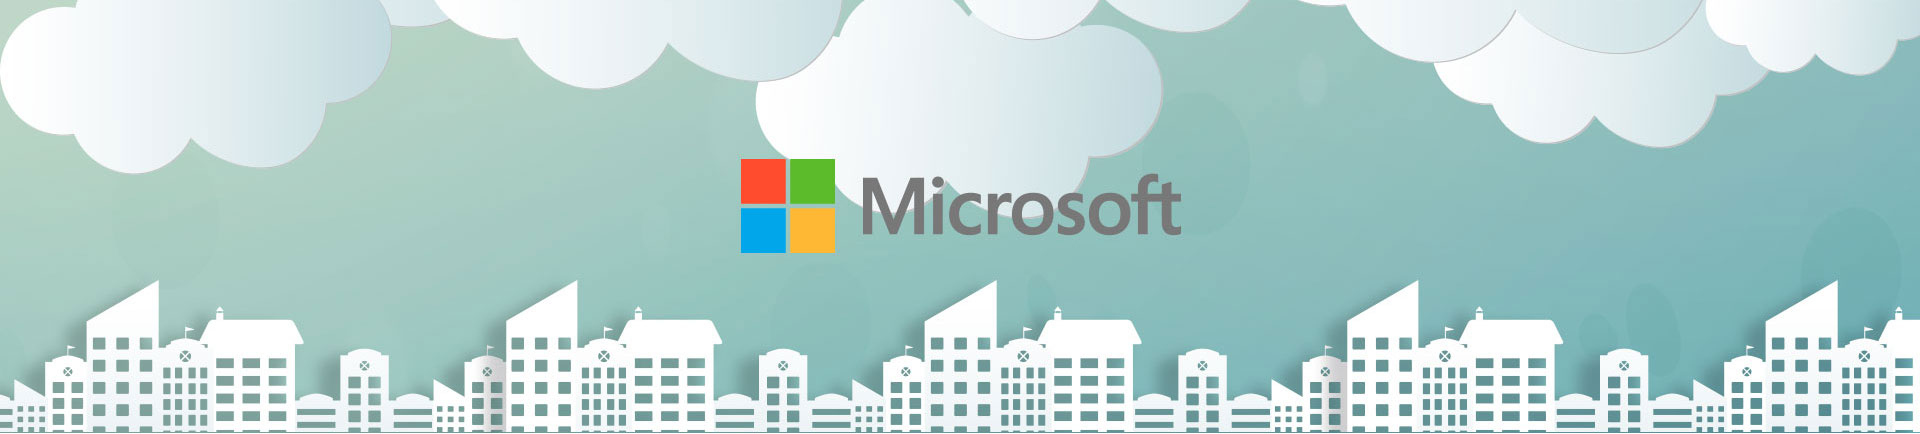

## Overview

We are trying to give Microsoft ideas on what genres of movies to film.

## Business Problem

3 Problems

## Data Understanding

Out of the available datasets, Imdb is the largest, with useful data on runtime, genres, and personnel. It's also more convenient to select which of these values we'd like to look at, as each data set has a `tconst` column that allows them to be stiched together. Unfortunately, Imdb lacks box office or budget data, so it needs to be merged with either The Numbers data set, or the Watch Mojo one. These three collectively are the most useful and what we'll be basing our recommendations on.

In [1]:
import pandas as pd
import numpy as np

In [2]:
box_mojo_df = pd.read_csv('data/bom.movie_gross.csv')
numbers_df = pd.read_csv('data/tn.movie_budgets.csv')
title_basics_df = pd.read_csv('data/imdb.title.basics.csv')
name_basics_df = pd.read_csv('data/imdb.name.basics.csv')
crew_df = pd.read_csv('data/imdb.title.crew.csv')
principal_df = pd.read_csv('data/imdb.title.principals.csv')
ratings_df = pd.read_csv('data/imdb.title.ratings.csv')
tmdb_df = pd.read_csv('data/tmdb.movies.csv')

## Data Preparation

### Data Cleaning

In [3]:
# Organizing the imdb data for runtime analysis. Extracts columns needed to merge and the runtime data.
tb_df = title_basics_df[['primary_title', 'start_year', 'runtime_minutes']]
# Filter out movies that haven't been made yet, and those we don't have runtime data for.
tb_df = tb_df[tb_df['start_year'] < 2022]
tb_df = tb_df.dropna(axis=0, subset=['runtime_minutes'])
tb_df.head()

,primary_title,start_year,runtime_minutes
0,Sunghursh,2013,175.0
1,One Day Before the Rainy Season,2019,114.0
2,The Other Side of the Wind,2018,122.0
4,The Wandering Soap Opera,2017,80.0
5,A Thin Life,2018,75.0


In [4]:
# We change the year data to match the IMDB format of only the year number.
numbers_df['release_date'] = pd.to_datetime(numbers_df['release_date'])
numbers_df['release_year'] = numbers_df['release_date'].dt.year
tmdb_df['release_date'] = pd.to_datetime(tmdb_df['release_date'])
tmdb_df['release_year'] = tmdb_df['release_date'].dt.year
# Create a Month DateTime column of the release dates
numbers_df['month_dt'] = pd.to_datetime(numbers_df['release_date']).dt.month
# Create a Month string column of the release dates
numbers_df['month'] = numbers_df['release_date'].dt.month
numbers_df = numbers_df.drop('release_date', 1)

In [5]:
# Converting to integer types for visualizations later
cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
numbers_df[cols] = numbers_df[cols].replace('[\$,]', '', regex=True).astype('int64')

In [6]:
# Title case all title data to have a better chance of matching in the merge.
tb_df['primary_title'] = tb_df['primary_title'].str.title()
numbers_df['movie'] = numbers_df['movie'].str.title()
box_mojo_df['title'] = box_mojo_df['title'].str.title()
tmdb_df['title'] = tmdb_df['title'].str.title()

In [7]:
# Adding profit margin columns
numbers_df['dom_profit_margin'] = (numbers_df['domestic_gross'] - numbers_df['production_budget']) / numbers_df['domestic_gross']
numbers_df['ww_profit_margin'] = (numbers_df['worldwide_gross'] - numbers_df['production_budget']) / numbers_df['worldwide_gross']

In [8]:
# Adding a column 'world_wide_profit_amount' that is the worldwide gross minus the production budget
numbers_df['world_wide_profit_amount'] = (numbers_df['worldwide_gross'] - numbers_df['production_budget'])

# Adding a ROI column that is the net profit amount divided by production budget. ROI = net / expense 
numbers_df['ROI_perc'] = (numbers_df['world_wide_profit_amount']  / numbers_df['production_budget']) * 100

In [9]:
# Making numbers_df only the years after 2000
numbers_df = numbers_df[numbers_df['release_year'] > 2000]

In [10]:
# Create a new data frame grouped by months and their median values.
month_df = numbers_df.groupby('month').median()

# Reset the index
month_df = month_df.reset_index()

# Sort the months in order
month_df = month_df.sort_values('month_dt')

# Add the names of the month
month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', \
                    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
month_df['month_name'] = month_dict.values() 

numbers_df.sort_values('release_year')

,id,movie,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,month,dom_profit_margin,ww_profit_margin,world_wide_profit_amount,ROI_perc
1209,10,The One,49000000,43905746,72689126,2001,11,11,-0.116027,0.325896,23689126,48.345155
352,53,Town & Country,105000000,6712451,10364769,2001,4,4,-14.642572,-9.130472,-94635231,-90.128791
2299,100,Say It Isn'T So,25000000,5516708,5516708,2001,3,3,-3.531688,-3.531688,-19483292,-77.933168
344,45,Ali,109000000,58183966,87683966,2001,12,12,-0.873368,-0.243101,-21316034,-19.555994
342,43,The Lord Of The Rings: The Fellowship Of The Ring,109000000,315544750,887210985,2001,12,12,0.654566,0.877143,778210985,713.955032
...,...,...,...,...,...,...,...,...,...,...,...,...
671,72,355,75000000,0,0,2019,12,12,-inf,-inf,-75000000,-100.000000
121,22,Dumbo,170000000,113883318,345004422,2019,3,3,-0.492756,0.507253,175004422,102.943778
194,95,Moonfall,150000000,0,0,2020,12,12,-inf,-inf,-150000000,-100.000000
535,36,Call Of The Wild,82000000,0,0,2020,2,2,-inf,-inf,-82000000,-100.000000


### Merging Datasets

Merging The Numbers data set and Imdb for runtime and box office gross comparisons.

In [11]:
# Merge on title and year to avoid incorrect matches on movies that have the same name.
numbers_and_tb = numbers_df.merge(tb_df,left_on=['movie', 'release_year'],right_on=['primary_title', 'start_year'],how='inner')
numbers_and_tb = numbers_and_tb.loc[numbers_and_tb['domestic_gross'] > 0]

In [12]:
new_movie = box_mojo_df[['title', 'studio', 'year']].merge(numbers_df, left_on=['title', 'year'], right_on=['movie', 'release_year'])

In [13]:
avg_studio = new_movie.groupby('studio').mean().reset_index()
avg_studio = avg_studio[avg_studio['dom_profit_margin'] > 0]

In [14]:
# Merge The Numbers and Tmdb to get box office and budget together with genres
genre_df = numbers_df.merge(tmdb_df, left_on=['movie', 'release_year'], right_on=['title', 'release_year'])
genre_df.loc[:,'genre_ids'] = genre_df['genre_ids'].map(lambda genre_string: genre_string.strip('[]').split(', '))
genre_ids_df = genre_df.explode('genre_ids')

# genre key for ids in Tmdb
genre_converter = pd.read_csv('genre_list.csv')
genre_converter['id'] = genre_converter['id'].astype('str')
genre_converter.rename(columns={"id": "genre_ids", "name": "genre_name"}, inplace=True)
genre_overall = genre_ids_df.merge(genre_converter, on="genre_ids")

## Analysis

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

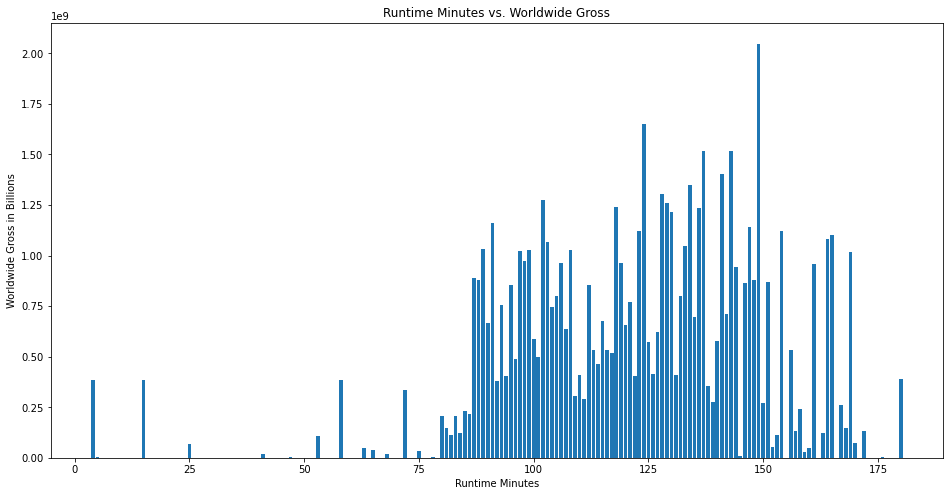

In [16]:
fig, ax = plt.subplots(figsize=(16, 8))


ax.bar(numbers_and_tb['runtime_minutes'], numbers_and_tb['worldwide_gross'],)


ax.tick_params(axis="x")
ax.set_xlabel("Runtime Minutes")
ax.set_ylabel("Worldwide Gross in Billions")
ax.set_title("Runtime Minutes vs. Worldwide Gross");

Text(0, 0.5, 'Domestic Profit Margin')

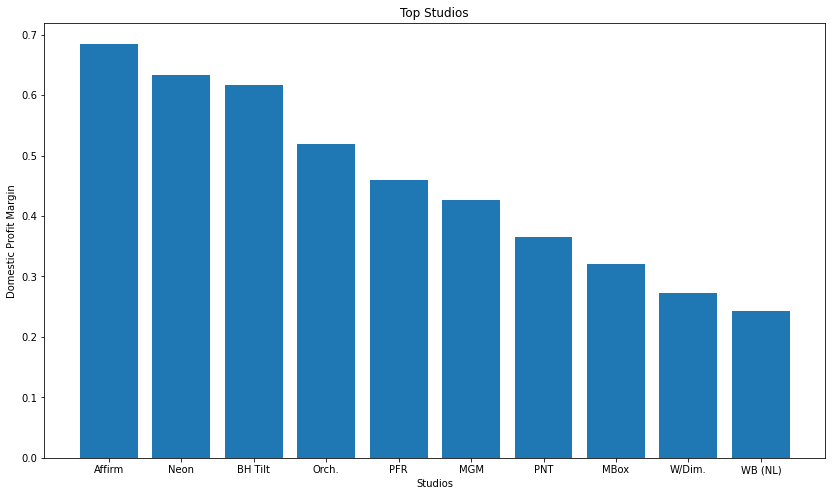

In [17]:
avg_studio = avg_studio.sort_values('dom_profit_margin', ascending=False).iloc[:10]

fig, ax= plt.subplots(figsize=(14,8))

ax.bar(avg_studio['studio'], avg_studio['dom_profit_margin'])
ax.set_title('Top Studios')
ax.set_xlabel('Studios')
ax.set_ylabel('Domestic Profit Margin')

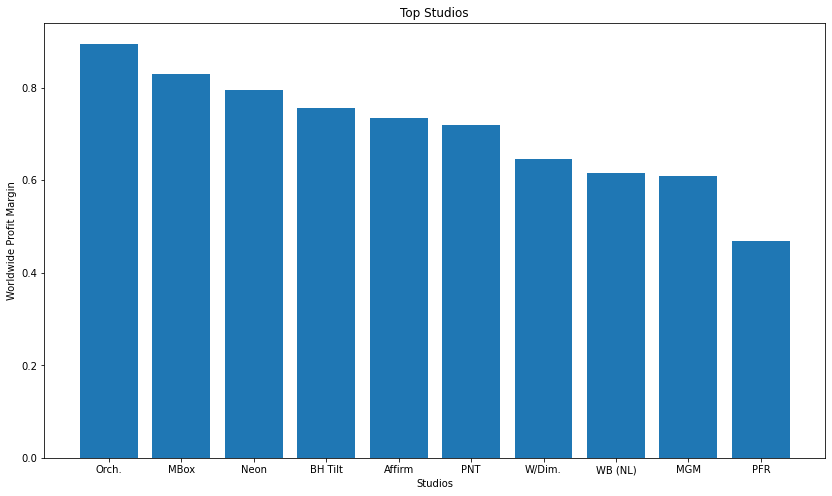

In [18]:
avg_studio = avg_studio.sort_values('ww_profit_margin', ascending=False).iloc[:10]

fig, ax= plt.subplots(figsize=(14,8))

ax.bar(avg_studio['studio'], avg_studio['ww_profit_margin'])
ax.set_title('Top Studios')
ax.set_xlabel('Studios')
ax.set_ylabel('Worldwide Profit Margin');

In [19]:
# Graphing Parameters
month = month_df['month_name']
profit_amount = month_df['world_wide_profit_amount']
ROI = month_df['ROI_perc']
wwgross = month_df['worldwide_gross']

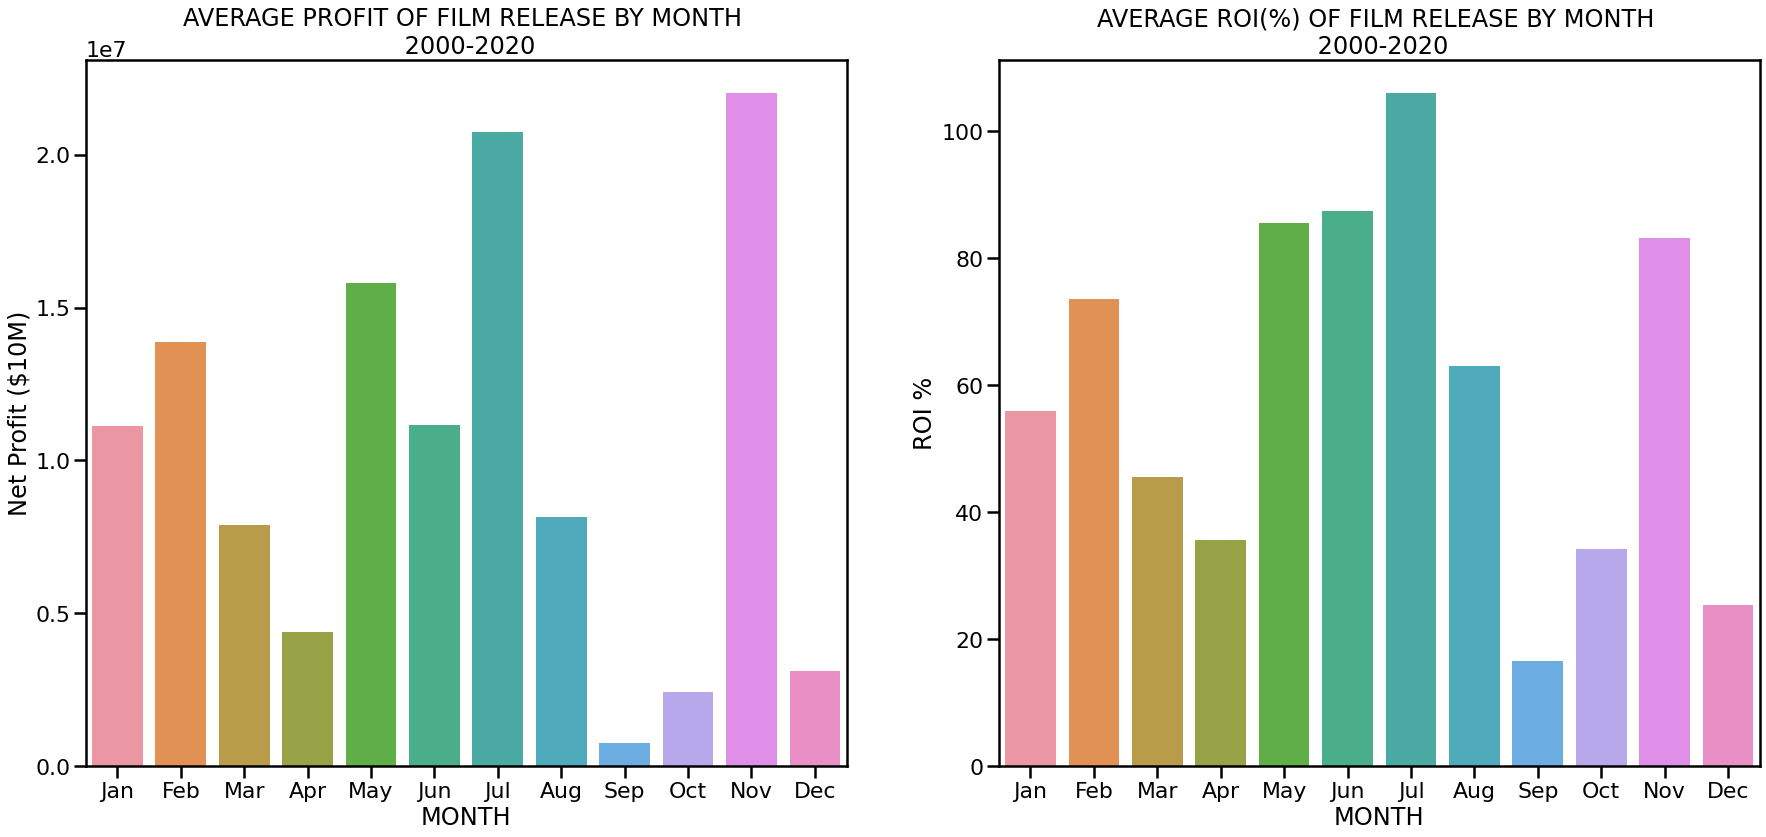

In [23]:
# Graph a barplot with months on the x axis and median profit margin/ROI amount on the y axis
fig, axs = plt.subplots(figsize=(30,13), ncols=2)

sns.barplot(x=month, y=profit_amount, ax=axs[0])
sns.barplot(x=month, y=ROI, ax=axs[1])
sns.set_context('poster')

axs[0].set_xlabel('MONTH')
axs[0].set_ylabel('Net Profit ($10M)')
axs[0].set_title(label='AVERAGE PROFIT OF FILM RELEASE BY MONTH \n 2000-2020')

axs[1].set_xlabel('MONTH')
axs[1].set_ylabel('ROI %')
axs[1].set_title(label='AVERAGE ROI(%) OF FILM RELEASE BY MONTH \n 2000-2020');

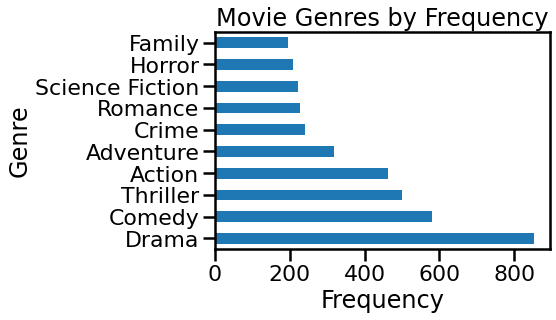

In [21]:
fig, ax= plt.subplots()

genre_overall['genre_name'].value_counts()[:10].plot(kind='barh')
ax.set_xlabel('Frequency')
ax.set_ylabel('Genre')
ax.set_title('Movie Genres by Frequency');

## Conclusions